In [1]:
import os
import cv2
import glob
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow.keras.callbacks import EarlyStopping
tf.random.set_seed(42)

In [2]:
ROOT_DIR = os.getcwd()
RAW_DATA_DIR = os.path.join(ROOT_DIR, 'data', 'raw')
class_name = {'0':0, '1':1, '2':2, '3':3, '4':4, '5':5, '6':6, '7':7, '8':8, '9':9}

In [3]:
PATHs, LABELs = [], []
for root,dir,_ in os.walk(RAW_DATA_DIR):
    for folder in dir:
      print(folder)
      label = class_name[folder]
      print
      filenames = glob.glob(os.path.join(root, folder, '*.JPG'))
      labels_np = np.ones(len(filenames), dtype=np.int32) * label
      PATHs.extend(filenames)
      LABELs.extend(labels_np)

0
1
2
3
4
5
6
7
8
9


In [4]:
len(PATHs), len(LABELs)

(2062, 2062)

In [5]:
metadata = pd.DataFrame({'path':PATHs, 'label':LABELs})
metadata.head()

,path,label
0,c:\Users\brian\Documents\projects\sign-languag...,0
1,c:\Users\brian\Documents\projects\sign-languag...,0
2,c:\Users\brian\Documents\projects\sign-languag...,0
3,c:\Users\brian\Documents\projects\sign-languag...,0
4,c:\Users\brian\Documents\projects\sign-languag...,0


<Axes: xlabel='label'>

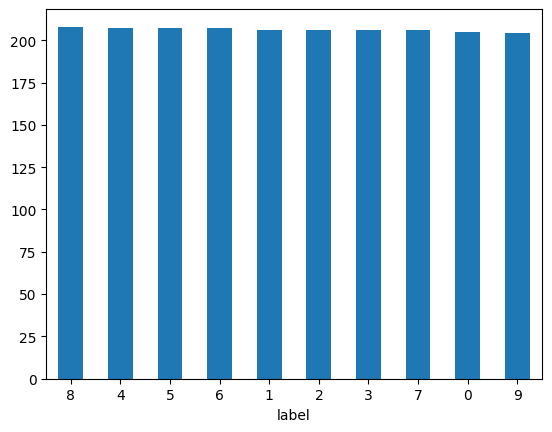

In [6]:
metadata['label'].value_counts().plot.bar(rot=0)

In [7]:
metadata.to_csv(os.path.join(ROOT_DIR, 'data', 'metadata.csv'), index=False)

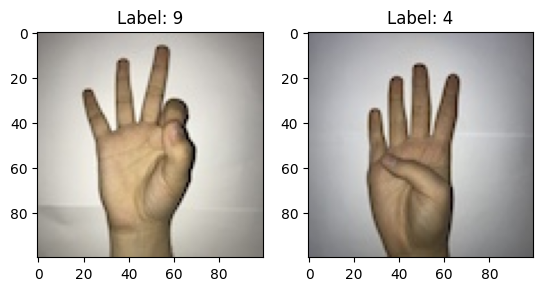

In [8]:
def read_image(metadata, idx):
    sample_data = metadata.iloc[idx]
    image = cv2.imread(sample_data['path'])
    image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
    return image, sample_data["label"]


image1, label1 = read_image(metadata, 2000)
image2, label2 = read_image(metadata, 1000)
fig, (ax1,ax2) = plt.subplots(1,2)
ax1.imshow(image1, cmap='gray')
ax1.set_title(f'Label: {label1}')
ax2.imshow(image2, cmap='gray')
ax2.set_title(f'Label: {label2}')
plt.show()

# Pipeline

In [9]:
train_data, val_data = tf.keras.utils.image_dataset_from_directory('data/raw',
                                                                   labels='inferred',
                                                                   label_mode='int',
                                                                   color_mode='grayscale',
                                                                   batch_size=8,
                                                                   image_size=(64,64),
                                                                   shuffle=True,
                                                                   seed=42,
                                                                   validation_split=0.1,
                                                                   subset='both')

Found 2062 files belonging to 10 classes.
Using 1856 files for training.
Using 206 files for validation.


In [10]:
def CNN(inp_shape=(64,64,1)):
    input_layer = tf.keras.Input(shape=inp_shape)
    rescale = tf.keras.layers.Rescalling(1./255.)(input_layer)
    cnn = tf.keras.layers.Conv2D(8, (5,5), padding='same', activation='relu')(input_layer)
    cnn = tf.keras.layers.MaxPool2D((8,8))(cnn)
    cnn = tf.keras.layers.Dropout(.25)(cnn)
    
    
    cnn = tf.keras.layers.Conv2D(16, (3,3), padding='same', activation='relu')(cnn)
    cnn = tf.keras.layers.MaxPool2D((2,2))(cnn)
    Dr2 = tf.keras.layers.Dropout(.25)(cnn)
    
    
    cnn = tf.keras.layers.Conv2D(32, (3,3), padding='same', activation='relu')(cnn)
    cnn = tf.keras.layers.MaxPool2D((2,2))(cnn)
    Dr3 = tf.keras.layers.Dropout(.25)(cnn)
    
    
    cnn = tf.keras.layers.Conv2D(64, (3,3), padding='same', activation='relu')(cnn)
    cnn = tf.keras.layers.MaxPool2D((2,2))(cnn)
    Dr4 = tf.keras.layers.Dropout(.25)(cnn)
   
    
    flatten = tf.keras.layers.Flatten()(cnn)
    out = tf.keras.layers.Dense(128, activation='relu')(flatten)
    out = tf.keras.layers.Dense(64, activation='relu')(out)
    outputs = tf.keras.layers.Dense(10, activation='softmax')(out)
    
    model = tf.keras.models.Model(inputs=input_layer, outputs=outputs)
    model.compile(optimizer='adam',
               loss='sparse_categorical_crossentropy',
               metrics=['accuracy'])
    return model

model = CNN()
model.summary()

Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer (InputLayer)        │ (None, 64, 64, 1)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d (Conv2D)                 │ (None, 64, 64, 8)      │           208 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d (MaxPooling2D)    │ (None, 8, 8, 8)        │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 8, 8, 8)        │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_1 (Conv2D)               │ (None, 8, 8, 16)       │         1,168 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_1 (MaxPooling2D)  │ (None, 4, 4, 16)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_2 (Conv2D)               │ (None, 4, 4, 32)       │         4,640 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_2 (MaxPooling2D)  │ (None, 2, 2, 32)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_3 (Conv2D)               │ (None, 2, 2, 64)       │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_3 (MaxPooling2D)  │ (None, 1, 1, 64)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 128)            │         8,320 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 64)             │         8,256 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 10)             │           650 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 41,738 (163.04 KB)

 Trainable params: 41,738 (163.04 KB)

 Non-trainable params: 0 (0.00 B)

In [11]:
early = EarlyStopping(monitor='val_accuracy',patience=20,verbose=0,
                      mode='max',restore_best_weights=True,
                      start_from_epoch=30)

history = model.fit(train_data,epochs=100,verbose=True,
                    validation_data=val_data,
                    callbacks=[early])


Epoch 1/100
232/232 ━━━━━━━━━━━━━━━━━━━━ 6s 10ms/step - accuracy: 0.1705 - loss: 3.1880 - val_accuracy: 0.3689 - val_loss: 1.6796
Epoch 2/100
232/232 ━━━━━━━━━━━━━━━━━━━━ 2s 10ms/step - accuracy: 0.4526 - loss: 1.5202 - val_accuracy: 0.6990 - val_loss: 0.8883
Epoch 3/100
232/232 ━━━━━━━━━━━━━━━━━━━━ 2s 9ms/step - accuracy: 0.6402 - loss: 1.0225 - val_accuracy: 0.8252 - val_loss: 0.5721
Epoch 4/100
232/232 ━━━━━━━━━━━━━━━━━━━━ 2s 9ms/step - accuracy: 0.7043 - loss: 0.8589 - val_accuracy: 0.8495 - val_loss: 0.4982
Epoch 5/100
232/232 ━━━━━━━━━━━━━━━━━━━━ 2s 9ms/step - accuracy: 0.7310 - loss: 0.7749 - val_accuracy: 0.8689 - val_loss: 0.4369
Epoch 6/100
232/232 ━━━━━━━━━━━━━━━━━━━━ 2s 8ms/step - accuracy: 0.7565 - loss: 0.6934 - val_accuracy: 0.8689 - val_loss: 0.4281
Epoch 7/100
232/232 ━━━━━━━━━━━━━━━━━━━━ 2s 8ms/step - accuracy: 0.7772 - loss: 0.6214 - val_accuracy: 0.8689 - val_loss: 0.4038
Epoch 8/100
232/232 ━━━━━━━━━━━━━━━━━━━━ 2s 9ms/step - accuracy: 0.7956 - loss: 0.6192 - val_ac

In [37]:
model.save_weights("model/cnn.weights.h5")

In [14]:
val_accuracy = history.history['val_accuracy']
val_loss = history.history['val_loss']
train_accuracy = history.history['accuracy']
train_loss = history.history['loss']


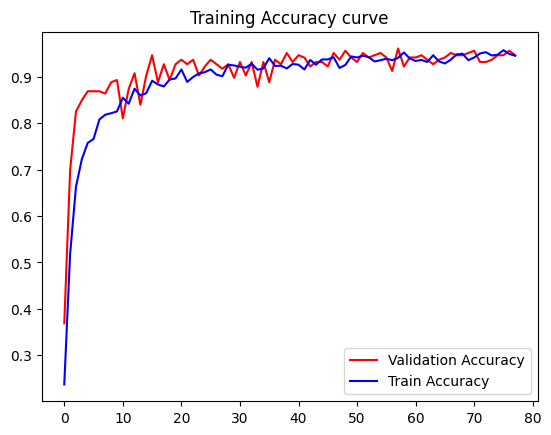

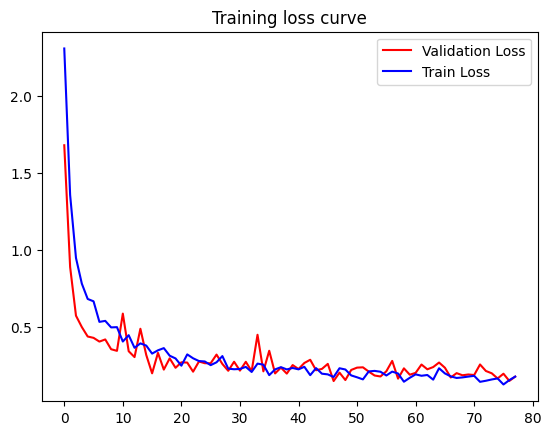

In [15]:
plt.figure()
plt.plot(val_accuracy,color='r',label='Validation Accuracy')
plt.plot(train_accuracy,color='b',label='Train Accuracy')
plt.title("Training Accuracy curve")
plt.legend()

plt.figure()
plt.plot(val_loss,color='r',label='Validation Loss')
plt.plot(train_loss,color='b',label='Train Loss')
plt.title("Training loss curve")
plt.legend()
plt.show()

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step


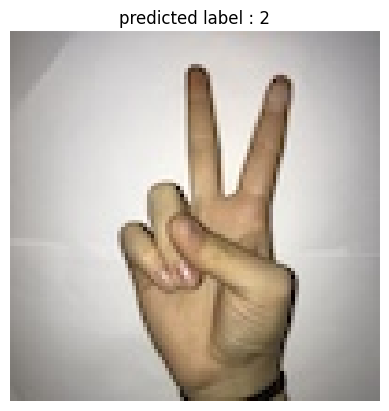

In [25]:
sample_test_rgb = cv2.cvtColor(cv2.imread('data\\test_images\\IMG_5983.JPG'), cv2.COLOR_BGR2RGB)
sample_test_image = cv2.imread('data\\test_images\\IMG_5983.JPG', cv2.IMREAD_GRAYSCALE)
sample_test_image_resized = cv2.resize(sample_test_image, (64,64))
sample_test_image_batch = np.expand_dims(sample_test_image_resized, axis=0)
y_pred = model.predict(sample_test_image_batch)
y_pred = np.argmax(y_pred)
plt.figure()
plt.imshow(sample_test_rgb)
plt.title(f'predicted label : {y_pred}')
plt.axis('off')
plt.show()

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step


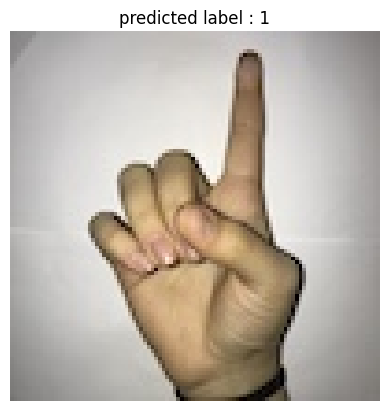

In [34]:
sample_test_rgb1 = cv2.cvtColor(cv2.imread('data\\test_images\\IMG_5982.JPG'), cv2.COLOR_BGR2RGB)
sample_test_image1 = cv2.imread('data\\test_images\\IMG_5982.JPG', cv2.IMREAD_GRAYSCALE)
sample_test_image_resized1 = cv2.resize(sample_test_image1, (64,64))
sample_test_image_batch1 = np.expand_dims(sample_test_image_resized1, axis=0)
y_pred1 = model.predict(sample_test_image_batch1)
y_pred1 = np.argmax(y_pred1)
plt.figure()
plt.imshow(sample_test_rgb1)
plt.title(f'predicted label : {y_pred1}')
plt.axis('off')
plt.show()

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step


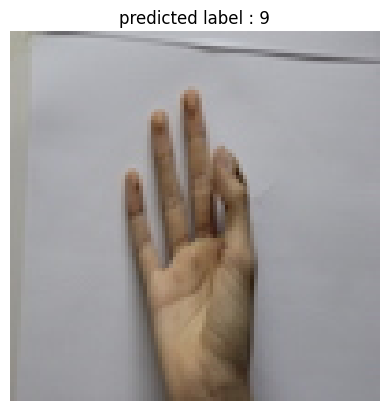

In [35]:
sample_test_rgb9 = cv2.cvtColor(cv2.imread('data\\test_images\\IMG_1238.JPG'), cv2.COLOR_BGR2RGB)
sample_test_image9 = cv2.imread('data\\test_images\\IMG_1238.JPG', cv2.IMREAD_GRAYSCALE)
sample_test_image_resized9 = cv2.resize(sample_test_image9, (64,64))
sample_test_image_batch9 = np.expand_dims(sample_test_image_resized9, axis=0)
y_pred9 = model.predict(sample_test_image_batch9)
y_pred9 = np.argmax(y_pred9)
plt.figure()
plt.imshow(sample_test_rgb9)
plt.title(f'predicted label : {y_pred9}')
plt.axis('off')
plt.show()